# backtesting with ATR adjustment

> The **average true range (ATR)** is a market volatility indicator used in technical analysis. It is typically derived from the 14-day simple moving average of a series of true range indicators. The ATR was initially developed for use in commodities markets but has since been applied to all types of securities.

In [1]:
from backtesting import Backtest, Strategy

import yfinance as yf
import pandas_ta as ta

import matplotlib.pyplot as plt

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [2]:
data = yf.download("^SPX", period="60d", interval="5m")

[*********************100%%**********************]  1 of 1 completed


In [3]:
class FallUp(Strategy):
    def init(self):
        self.down_days = 0
        self.hold_days = 0

    def next(self):
        # close price of previous day
        pv = self.data.Close[-2]

        # close price of current day
        cv = self.data.Close[-1]

        # consecutively falling N times and reversal, buy-in
        if self.down_days >= 5 and cv > pv and self.data['atr'] > 4:
            self.buy()
            self.hold_days = 0
            self.down_days_after_position = 0

        # record falling times
        if cv < pv:
            self.down_days += 1
        else:
            self.down_days = 0

        if self.position:
            self.hold_days += 1

            # record falling times after position
            if cv < pv:
                self.down_days_after_position += 1

            # 出現兩次連續下跌就平倉
            if self.down_days > 1:
                self.position.close()

            # 買入後，在4支k線範圍內如果出現1次下跌就平倉
            if self.hold_days <= 4 and self.down_days_after_position > 0:
                self.position.close()

pandas_ta 中有現成的 atr 可以用

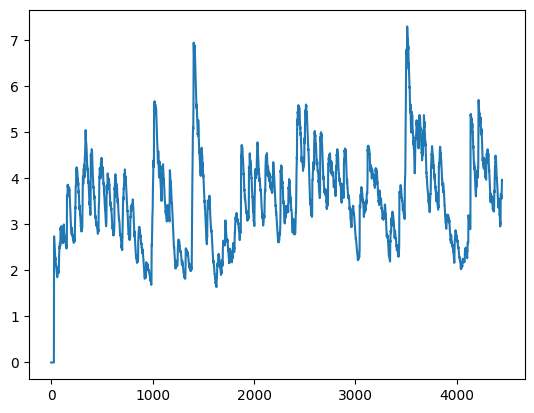

In [4]:
data['atr'] = ta.atr(data.High, data.Low, data.Close, length=28, fillna=0)

plt.plot(data['atr'].reset_index(drop=True))

In [5]:
data['atr'].describe()

count    4446.000000
mean        3.527605
std         0.992386
min         0.000000
25%         2.811409
50%         3.503060
75%         4.166651
max         7.301675
Name: atr, dtype: float64

atr 範圍在 0 - 7 之間，可以用 4 - 5 作為基準

In [6]:
bt = Backtest(
    data, 

    # Strategy
    FallUp, 

    # Commission
    commission=.002, 

    # 預設使用翌日的 Open 作為買賣價格，這裡改成使用當日的 close 作為買賣價格
    trade_on_close=True,

    # 每次只下 1 張單
    exclusive_orders=True 
)

stats = bt.run()

In [7]:
stats

Start                     2023-11-27 09:30...
End                       2024-02-16 15:55...
Duration                     81 days 06:25:00
Exposure Time [%]                    0.809717
Equity Final [$]                  9766.466021
Equity Peak [$]                       10000.0
Return [%]                           -2.33534
Buy & Hold Return [%]               10.020946
Return (Ann.) [%]                   -9.919934
Volatility (Ann.) [%]                1.207138
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                    -2.33534
Avg. Drawdown [%]                    -2.33534
Max. Drawdown Duration       74 days 05:20:00
Avg. Drawdown Duration       74 days 05:20:00
# Trades                                   14
Win Rate [%]                              0.0
Best Trade [%]                       -0.14057
Worst Trade [%]                     -0.317105
Avg. Trade [%]                    

In [8]:
stats._trades

,Size,EntryBar,ExitBar,EntryPrice,ExitPrice,PnL,ReturnPct,EntryTime,ExitTime,Duration
0,2,403,405,4559.741417,4550.859863,-17.763107,-0.001948,2023-12-04 10:35:00-05:00,2023-12-04 10:45:00-05:00,0 days 00:10:00
1,2,1062,1063,4720.782583,4709.520020,-22.525127,-0.002386,2023-12-14 13:30:00-05:00,2023-12-14 13:35:00-05:00,0 days 00:05:00
2,2,1394,1396,4726.384096,4719.740234,-13.287723,-0.001406,2023-12-20 15:10:00-05:00,2023-12-20 15:20:00-05:00,0 days 00:10:00
3,2,1412,1415,4742.175381,4730.790039,-22.770684,-0.002401,2023-12-21 10:10:00-05:00,2023-12-21 10:25:00-05:00,0 days 00:15:00
4,2,2021,2023,4719.891155,4713.029785,-13.722740,-0.001454,2024-01-03 15:25:00-05:00,2024-01-03 15:35:00-05:00,0 days 00:10:00
5,2,2266,2268,4744.289464,4735.140137,-18.298654,-0.001928,2024-01-09 09:50:00-05:00,2024-01-09 10:00:00-05:00,0 days 00:10:00
6,2,2606,2607,4773.207536,4762.979980,-20.455111,-0.002143,2024-01-16 12:10:00-05:00,2024-01-16 12:15:00-05:00,0 days 00:05:00
7,2,2684,2685,4746.133477,4735.620117,-21.026719,-0.002215,2024-01-17 12:10:00-05:00,2024-01-17 12:15:00-05:00,0 days 00:05:00
8,2,3528,3530,4866.623977,4855.810059,-21.627836,-0.002222,2024-02-01 11:00:00-05:00,2024-02-01 11:10:00-05:00,0 days 00:10:00
9,1,3677,3678,4938.808096,4927.779785,-11.028311,-0.002233,2024-02-05 10:25:00-05:00,2024-02-05 10:30:00-05:00,0 days 00:05:00


In [9]:
bt.plot()

/Users/kimfaicheang/workspace/snowball/venv/lib/python3.10/site-packages/backtesting/_plotting.py:455: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  df2 = (df.assign(_width=1).set_index('datetime')


Row(id='1408', ...)